In [134]:
import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [158]:


def load_data_stream(path):

    # the data stream is comma-separated values
    # but with multiple different event types
    # with a variable amount of actual data
    columns = ['event', 'tick'] + list(range(0,10))
    df = pandas.read_csv(path, header=None, names=columns, engine='python')
    
    return df

def extract_sensor_data(events, marker='val'):
    df = events[events.event == marker]
    df = df.rename(columns={0: 'r', 1: 'g', 2: 'b'})
    df = df[['tick', 'r', 'g', 'b']]
    df = df.set_index('tick')
    
    return df

def extract_button_data(events, marker='button'):
    df = events[events.event == marker]
    df = df.rename(columns={0: 'state'})
    df = df[['tick', 'state']]
    df = df.set_index('tick')
    return df
    
def load_color_detector_data(path):
    events = load_data_stream(path)
    
    sensor_data = extract_sensor_data(events)
    button_data = extract_button_data(events).rename(columns={'state': 'button'})
    
    # tick values are actually shared, can be merged easily into one time-series
    combined = pandas.merge(sensor_data, button_data, right_index=True, left_index=True)
    
    return combined

def load_data(path):
    import glob, os
    dfs = []
    for match in glob.glob(path):
        df = load_color_detector_data(match)
        df['filename'] = os.path.basename(match)
        df = df.reset_index().set_index(['filename', 'tick'])
        dfs.append(df)
    
    df = pandas.concat(dfs)
    return df
    
path = './data/cards-2hz-100ms-*.csv'
data = load_data(path)
data.head()

r     g      b  button
filename              tick                            
cards-2hz-100ms-2.csv 36000  84.0  37.0  193.0     0.0
                      36500  83.0  36.0  192.0     0.0
                      37000  84.0  36.0  193.0     0.0
                      37500  83.0  35.0  191.0     0.0
                      38000  84.0  36.0  192.0     0.0

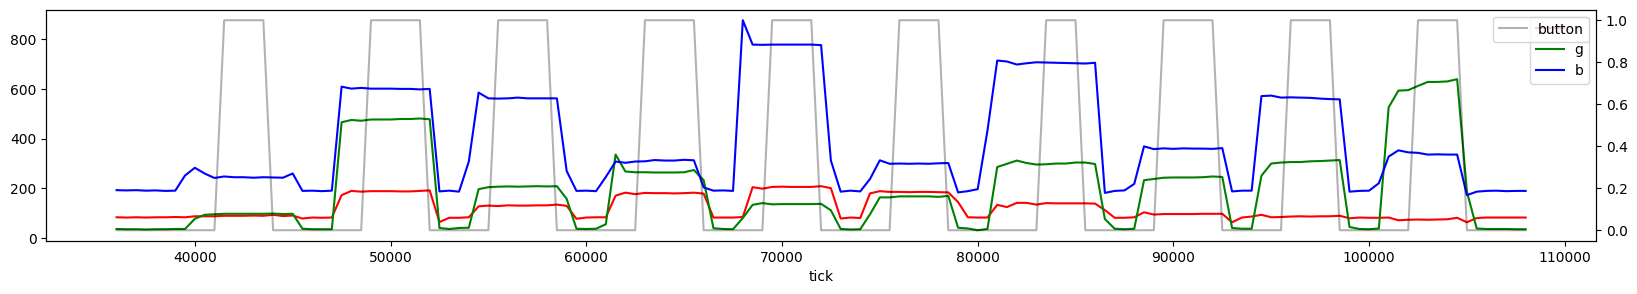

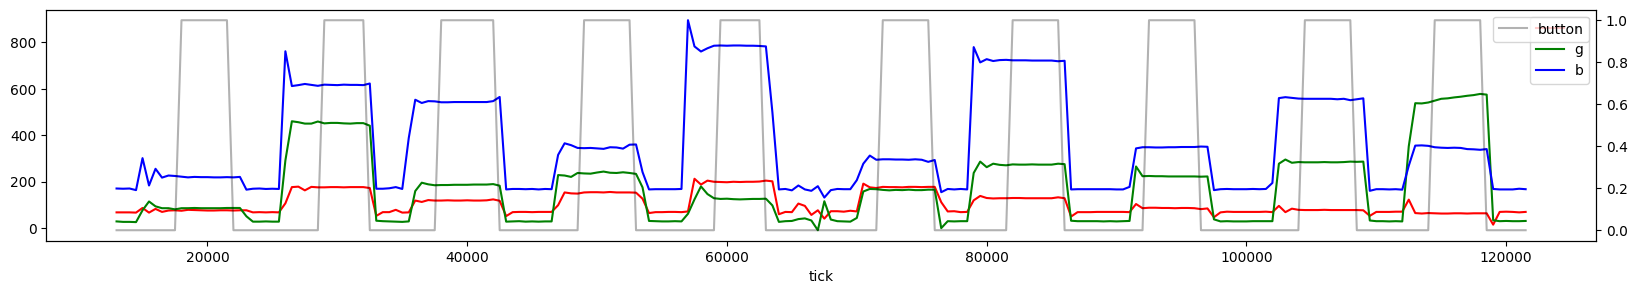

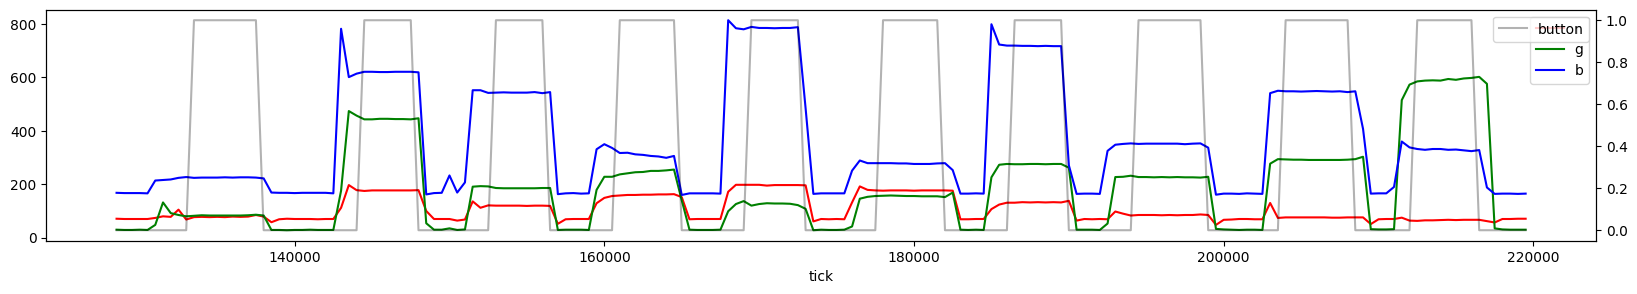

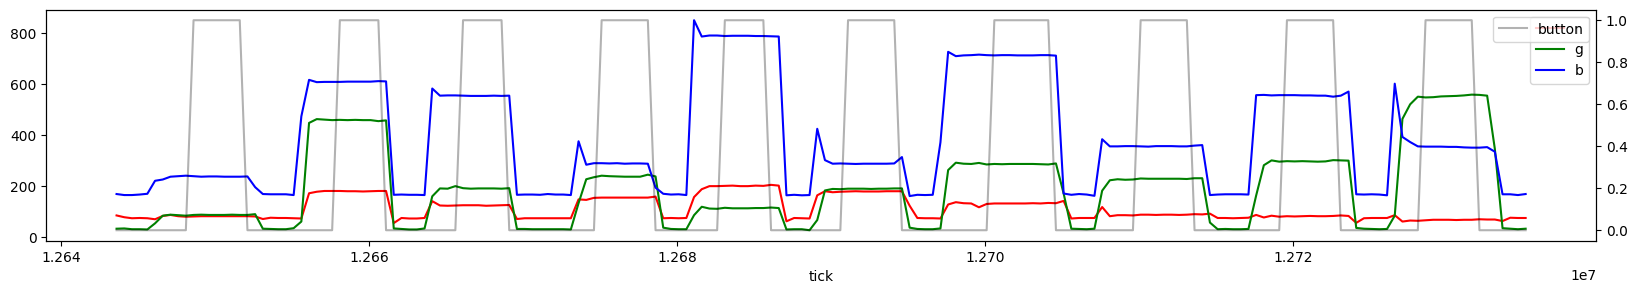

In [159]:

def plot_timeseries(data, time_column='tick'):
    dd = data.reset_index()
    
    # XXX: seaborn does not handle gaps with NaN values, but pandas.DataFrame.plot does
    fig, ax = plt.subplots(1, figsize=(20, 3))
    for col in ['r', 'g', 'b']:
        color = col
        dd.plot(ax=ax, x=time_column, y=col, color=color)

    ax2 = ax.twinx()
    dd.plot(ax=ax2, x=time_column, y='button', color='black', alpha=0.3) 
    return fig
    
for name, df in data.groupby('filename'):
    plot_timeseries(df)

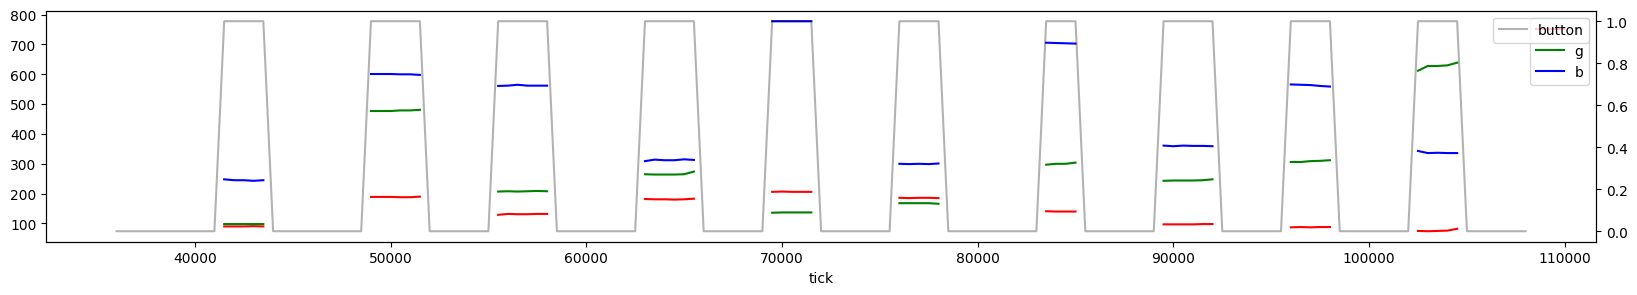

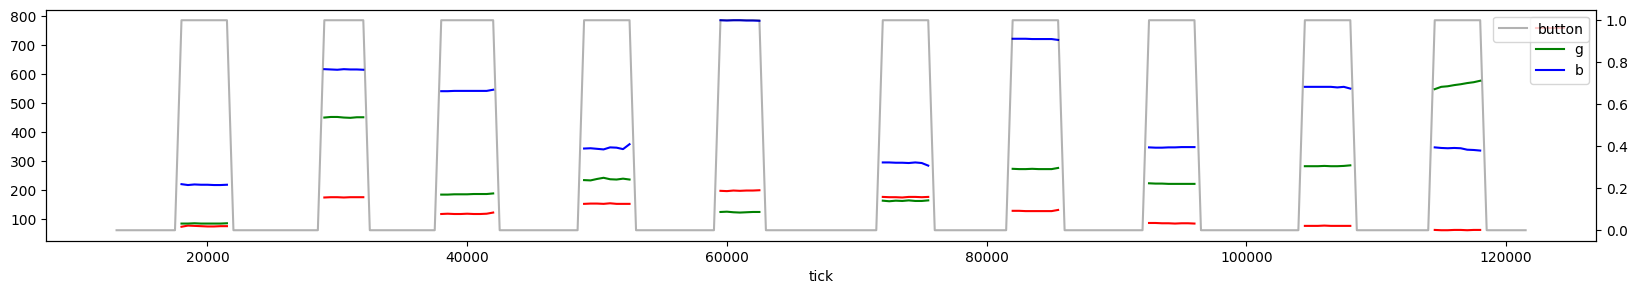

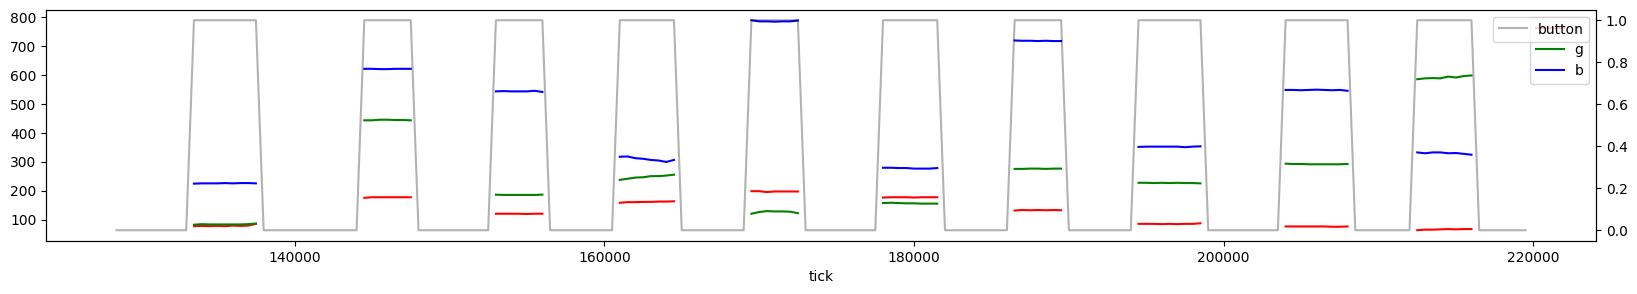

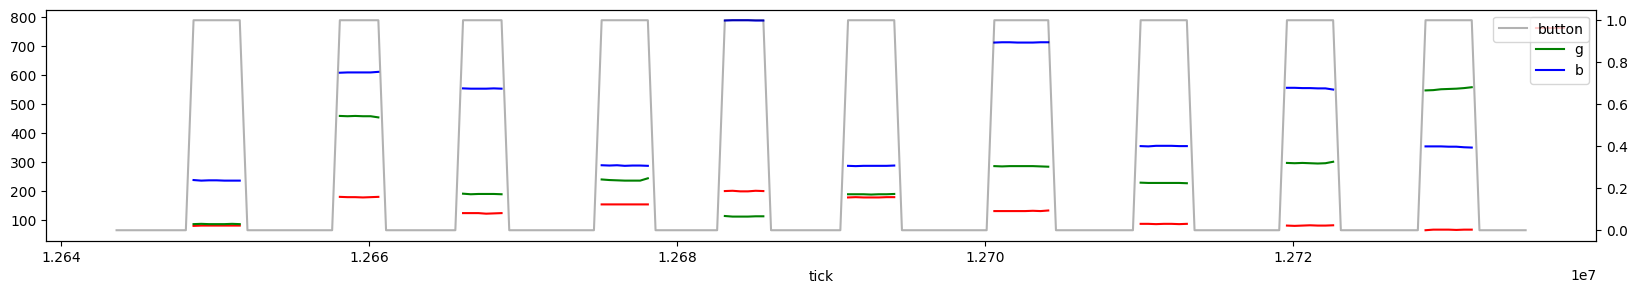

In [160]:

def mask_timeseries(df, mask_column, columns=None, value=numpy.nan):
    df = df.copy() # avoid mutating input
    
    if columns is None:
        columns = list(set(df.columns) - set([mask_column]))
    
    is_masked = df[mask_column].astype(bool) == False
    for col in columns:
        df.loc[is_masked, col] = value
    
    return df

for name, df in data.groupby('filename'):
    plot_timeseries(mask_timeseries(df, 'button'))
    

In [161]:
card_data_order = [
    'Black',
    'White',
    'Grey', # cardboard
    'Pink',
    'Yellow',
    'Red',
    'PaleGreen',
    'Purple',
    'Blue',
    'DarkBlue',
]
def make_label_mapping(section_labels):

    label_mapping = { numpy.nan: 'ambient' }
    for idx, label in enumerate(section_labels):
        label_mapping[idx] = label
    return label_mapping

label_mapping = make_label_mapping(card_data_order)
label_mapping

{nan: 'ambient',
 0: 'Black',
 1: 'White',
 2: 'Grey',
 3: 'Pink',
 4: 'Yellow',
 5: 'Red',
 6: 'PaleGreen',
 7: 'Purple',
 8: 'Blue',
 9: 'DarkBlue'}

In [162]:
def mark_sections(df, indicator, name='section'):
    assert len(df) == len(indicator)
    
    #dropped = df.dropna()
    
    section_number = -1
    section_labels = []
    in_section = indicator.iloc[0]
    for ind, (_, row) in zip(indicator, df.iterrows()):
        
        if not in_section and ind:
            # start section
            in_section = True
            section_number += 1
            
        if in_section and not ind:
            # end section
            in_section = False
        

        v = section_number if in_section else numpy.nan
        section_labels.append(v)
    
    s = pandas.Series(section_labels, index=df.index, name='section')
    #print(s.value_counts().sort_index())
    out = pandas.merge(df, s, right_index=True, left_index=True)
    return out

def label_data(data):
    
    def label_one(df):
        # TODO: ignore data just around the edge of button being pressed. Is probably not representative of "ambient"
        labeled_data = mark_sections(df, df['button'])
        #labeled_data.dropna(subset=['section'])
        labeled_data['label'] = labeled_data['section'].replace(label_mapping)
        return labeled_data
        
    grouped = data.groupby('filename', group_keys=False)
    out = grouped.apply(label_one)
    return out
    
labeled_data = label_data(data)
labeled_data['label'].value_counts(dropna=False)

ambient      451
Purple        30
Black         29
Pink          29
Blue          29
Grey          28
Red           28
DarkBlue      28
PaleGreen     27
White         26
Yellow        25
Name: label, dtype: int64

In [167]:


cards_color_map = dict(zip(label_mapping.values(), label_mapping.values()))
cards_color_map.update({
    'ambient': 'Sienna',
    'White': 'Beige', 
})
cards_color_map

{'ambient': 'Sienna',
 'Black': 'Black',
 'White': 'Beige',
 'Grey': 'Grey',
 'Pink': 'Pink',
 'Yellow': 'Yellow',
 'Red': 'Red',
 'PaleGreen': 'PaleGreen',
 'Purple': 'Purple',
 'Blue': 'Blue',
 'DarkBlue': 'DarkBlue'}

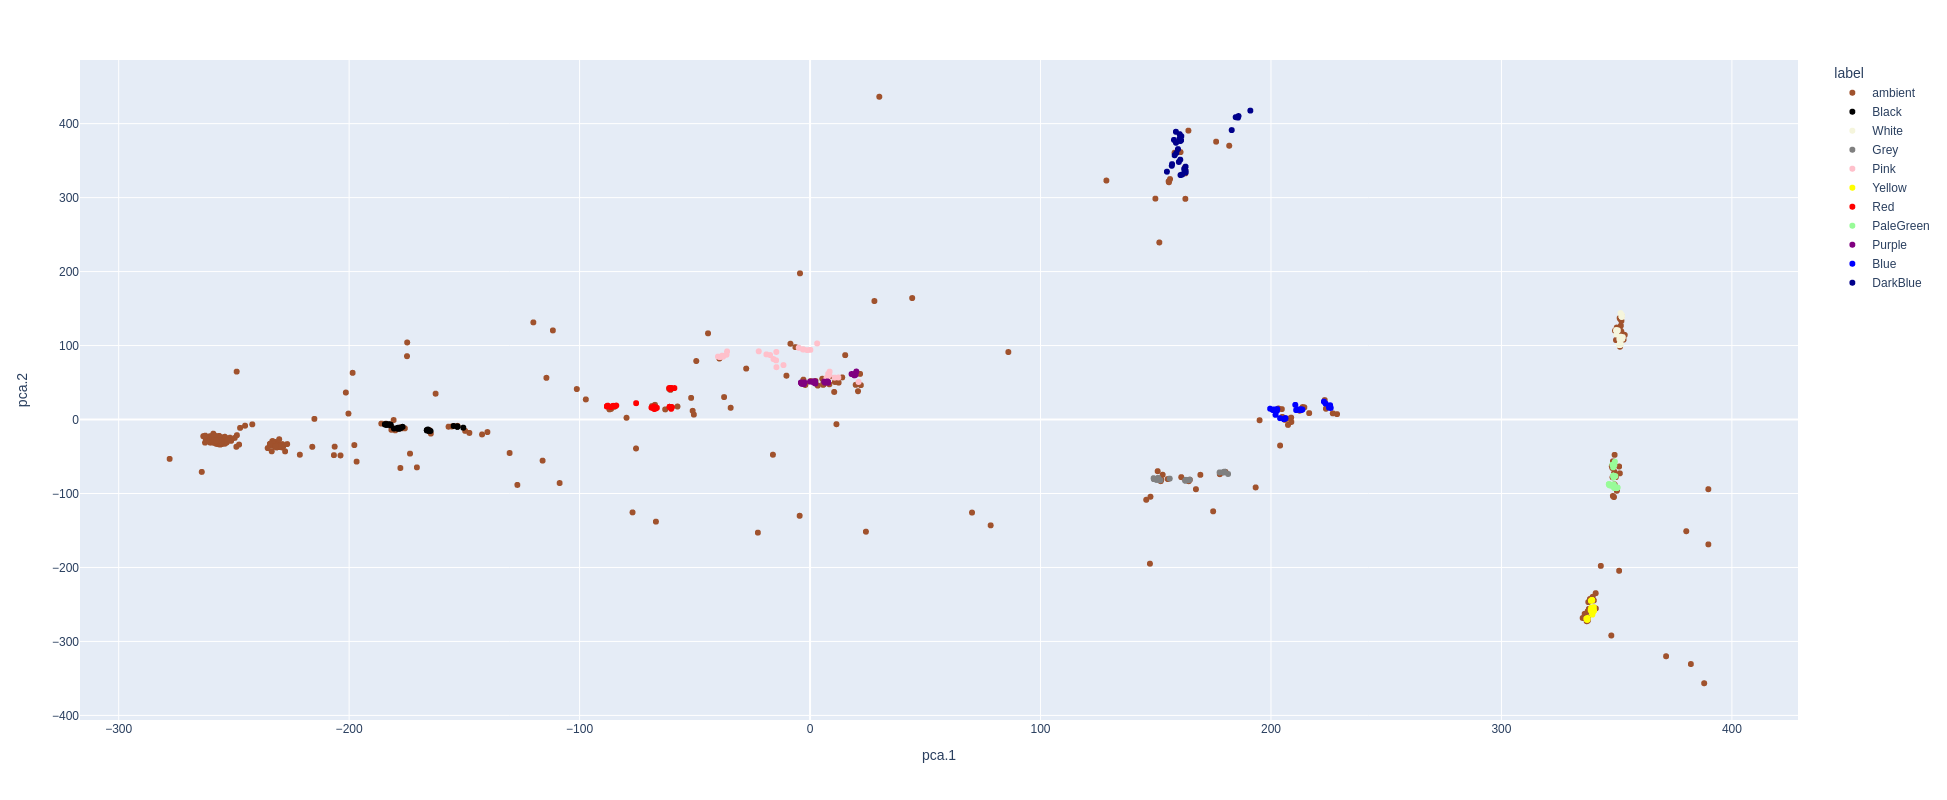

In [170]:

def pca_transform_2d(data, columns = ['r', 'g', 'b']):
    from sklearn.decomposition import PCA
  
    pca = PCA(2)
    data = data.dropna(subset=columns)
    
    X = data[columns]
    dd = pca.fit_transform(X)
    df = pandas.DataFrame(dd, columns=['pca.1', 'pca.2'], index=data.index)
    return df

def plot_colors_2d(data, color_map={}):

    pca_data = pca_transform_2d(data)
    modded = pandas.merge(data, pca_data, right_index=True, left_index=True).reset_index()
    
    import plotly.express
    # FIXME: plot with (approximately) correct colors
    fig = plotly.express.scatter(modded, x='pca.1', y='pca.2',
                                 color='label',
                                 hover_data=['filename'],
                                 color_discrete_map=color_map,
                                 height=800, width=800)
    return fig

fig = plot_colors_2d(labeled_data, color_map=cards_color_map)
fig

In [ ]:
from sklearn.semi_supervised import LabelSpreading

def propagate_labels(data):
    label_prop = LabelSpreading()

    X = pca_transform_2d(data)
    labels = data['label']
    
    labels[random_unlabeled_points] = -1
    label_prop_model.fit(X, labels)


In [ ]:
# TODO: train a RandomForest classifer on RGB space



In [ ]:
# TODO: use emlearn to convert, write C code output